In [53]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image
import os

In [54]:
image_path = [
    r"D:\Programming\Projects\phishguard-vision\data\train\phishing\adobe\adobe (9).png",
]

In [106]:
image = cv2.imread(image_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image)
image[0][0]

array([255,   0,   0], dtype=uint8)

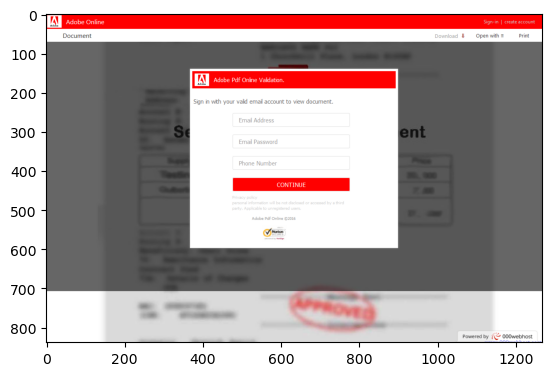

In [107]:
plt.imshow(image)

In [38]:
# Function to plot images

def plot_images(images_dict, cols = 2, title= None, figwidth=15, ):
    num_images = len(images_dict)
    rows = (num_images + cols - 1) // cols
    
    plt.figure(figsize=(figwidth, 5 * rows))
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    for i, (image_name, image_data) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        image_data = np.array(image_data)
        plt.imshow(image_data, cmap='gray')
        plt.title(image_name)
        # plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [116]:
def apply_high_pass_filter(channel):
    # Get the image dimensions
    rows, cols = channel.shape
    
    # Apply DFT
    dft = cv2.dft(np.float32(channel), flags=cv2.DFT_COMPLEX_OUTPUT)
    
    # Shift the zero frequency component (DC component) to the center
    dft_shifted = np.fft.fftshift(dft)
    
    # Create a high-pass filter mask: center is 0, corners are 1
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    r = 20  # Radius for high-pass filter, adjust as needed
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask[mask_area] = 0

    # Apply the mask to the shifted DFT
    dft_shifted_filtered = dft_shifted * mask
    
    # Inverse shift to move the DC component back to original position
    dft_inverse_shifted = np.fft.ifftshift(dft_shifted_filtered)
    
    # Apply inverse DFT to get the filtered image
    img_back = cv2.idft(dft_inverse_shifted)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    # Normalize for display
    cv2.normalize(img_back, img_back, 0, 255, cv2.NORM_MINMAX)
    
    return np.uint8(img_back)

In [117]:
image.shape

(838, 1268, 3)

In [118]:
b_channel, g_channel, r_channel = cv2.split(image)

# Apply high-pass filter to each channel
filtered_b = apply_high_pass_filter(b_channel)
filtered_g = apply_high_pass_filter(g_channel)
filtered_r = apply_high_pass_filter(r_channel)

filtered_image = cv2.merge([filtered_b, filtered_g, filtered_r])

In [119]:
filtered_image.shape

(838, 1268, 3)

In [120]:
original_float = np.float32(image)
filtered_float = np.float32(filtered_image)

alpha = 0.7  # weight for original image
beta = 0.7   # weight for high-pass filtered image

highlighted_image = cv2.addWeighted(original_float, alpha, filtered_float, beta, 0)

highlighted_image = np.uint8(np.clip(highlighted_image, 0, 255))


In [121]:
result = {
    "Og" : image,
    "main" : filtered_image,
    "add" : highlighted_image
}

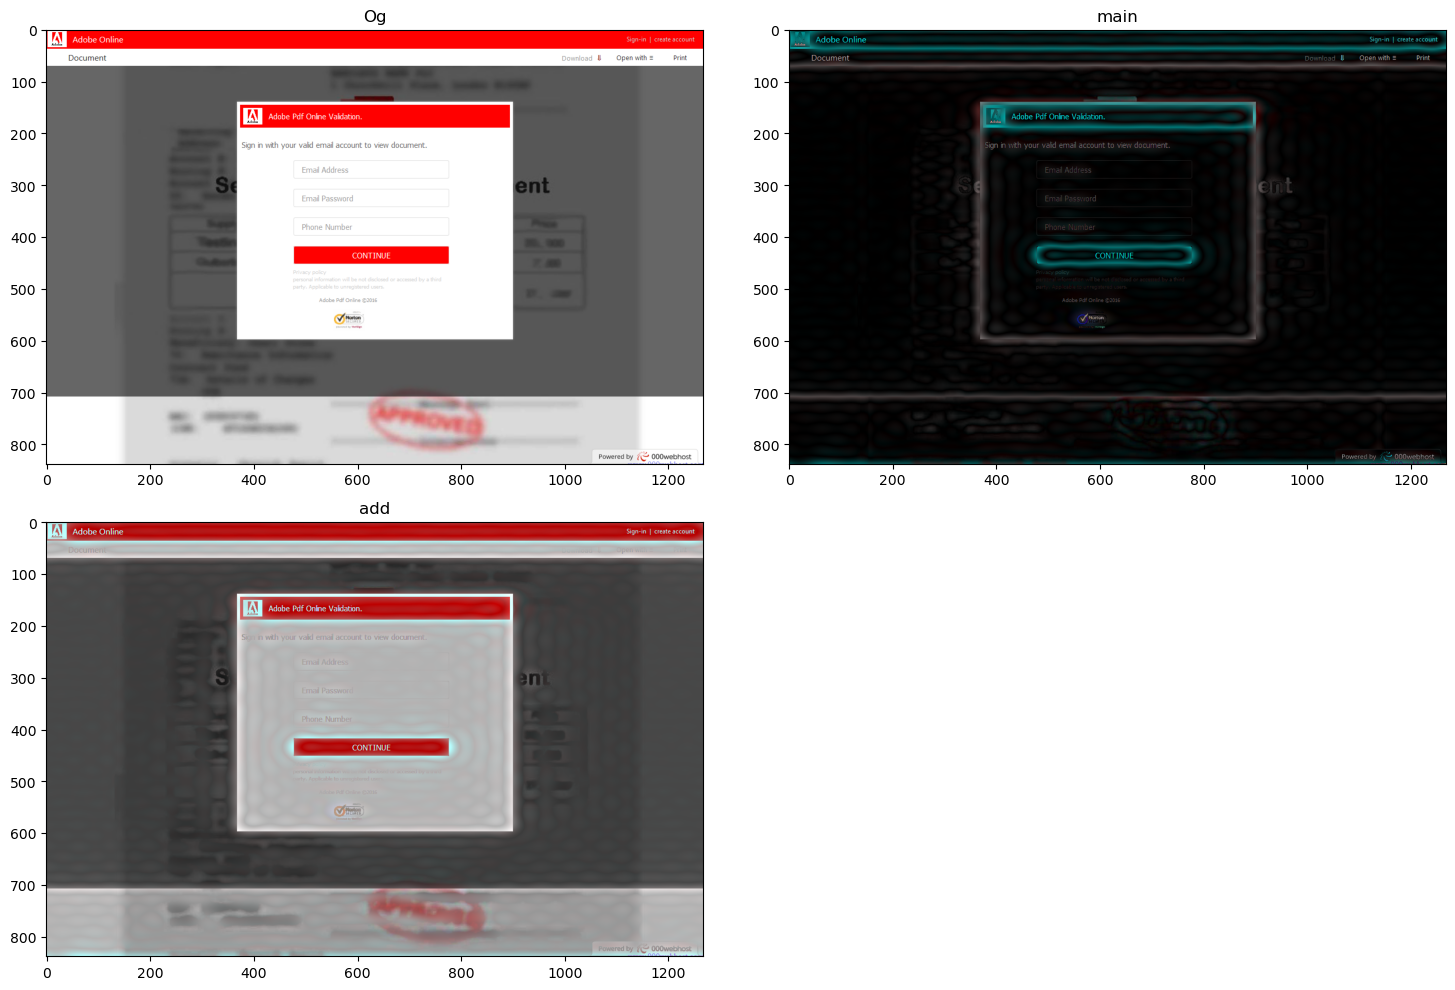

In [122]:
plot_images(result)

In [44]:
# DFT-based filter

def apply_pass_filter(x, filter_type = 'low', filter_radius=30):
    image = x.copy()
    dft = np.fft.fft2(image)
    dft_shifted = np.fft.fftshift(dft)

    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2

    mask = np.zeros((rows, cols), np.uint8)
    for u in range(rows):
        for v in range(cols):
            distance = np.sqrt((u - crow)**2 + (v - ccol)**2)
            if filter_type == 'low':
                if distance < filter_radius:
                    mask[u, v] = 1
            else:
                if distance > filter_radius:
                    mask[u, v] = 1

    dft_shifted_filtered = dft_shifted * mask

    dft_filtered = np.fft.ifftshift(dft_shifted_filtered)
    filtered_image = np.fft.ifft2(dft_filtered)
    filtered_image = np.abs(filtered_image)

    result = {
        'Original Image': image,
        'Original Spectrum': np.log(1 + np.abs(dft_shifted)),
        'Filtered Image': filtered_image,
        'Filtered Spectrum': np.log(1 + np.abs(dft_shifted_filtered)),
        'Aggregated Image' : filtered_image + image
    }

    
    return result

In [45]:
result = apply_pass_filter(image, 'high')

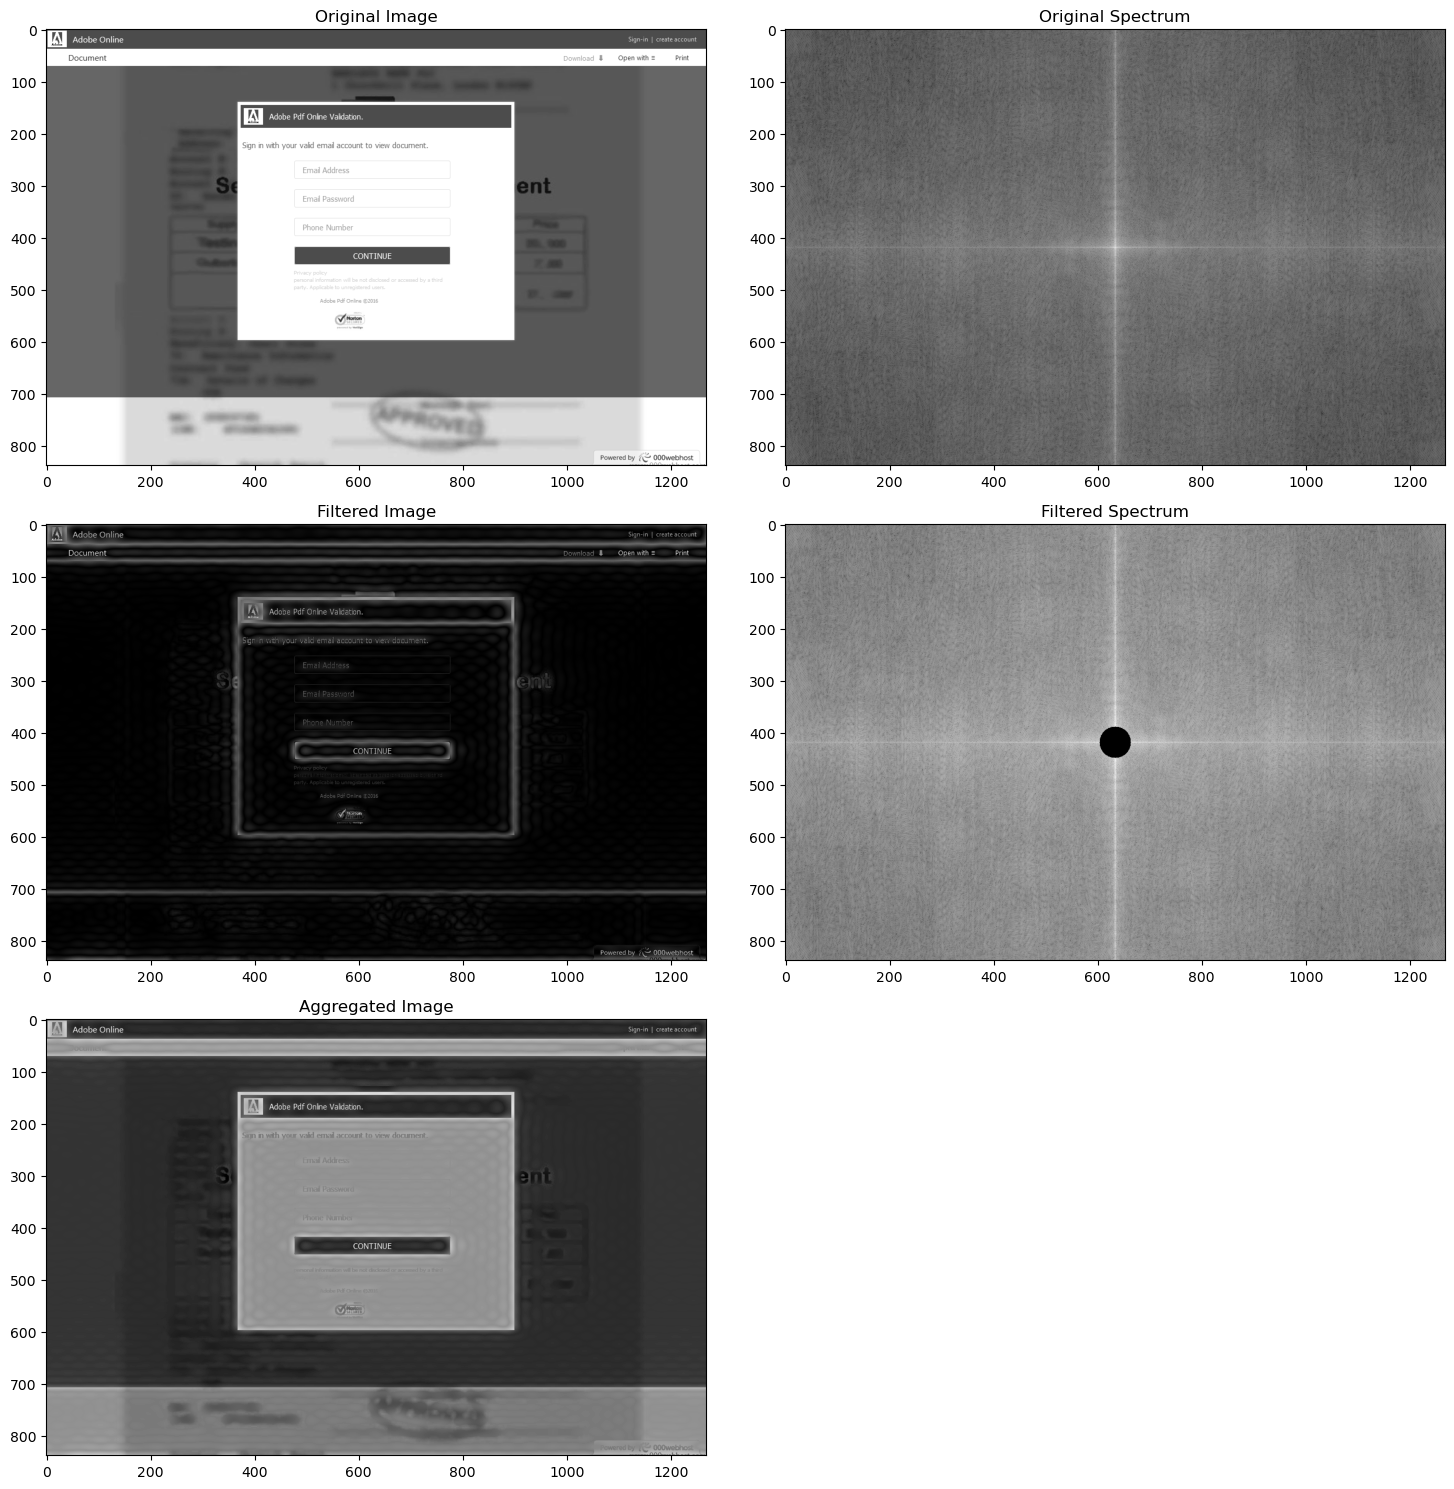

In [46]:
plot_images(result)

In [48]:
result['Filtered Image'].shape

(838, 1268)